<a href="https://colab.research.google.com/github/icculp/holbertonschool-machine_learning/blob/main/reinforcement_learning/0x01-deep_q_learning/train_and_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul  5 00:13:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!pip install keras-rl2
!pip install gym
!pip install gym[atari]
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
     |████████████████████████████████| 61kB 4.8MB/s 
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/ata

In [4]:
import rl
import keras as K
import gym
from rl.agents.dqn import DQNAgent
from rl.core import Processor
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, GreedyQPolicy
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [5]:
env = gym.make('Breakout-v0')   # 'Breakout-ram-v0')  # Breakout-v0')
env.reset()
# height, width, channels = 
# print(env.observation_space.shape)
shp = env.observation_space.shape
print(shp)
actions = env.action_space.n
print(actions)

(210, 160, 3)
4


In [13]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = K.layers.Input((actions,) + shp) 
    # [:-1]) #  (84, 84, 4,)) #  # shape=(1, 1, 128)) # (84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = K.layers.Conv2D(32, 8, strides=4, name='conv1', activation="relu")(inputs)
    layer2 = K.layers.Conv2D(64, 4, strides=2, name='conv2', activation="relu")(layer1)
    layer3 = K.layers.Conv2D(64, 3, strides=1, name='conv3', activation="relu")(layer2)

    layer4 = K.layers.Flatten()(layer3)

    layer5 = K.layers.Dense(512, activation="relu", name='dense1')(layer4)
    action = K.layers.Dense(actions, activation="linear", name='dense2')(layer5)

    return K.Model(inputs=inputs, outputs=action)

In [18]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=100000, window_length=actions)
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1,
                                  value_test=.05, nb_steps=100000)
    # processor = AtariProcessor()
    agent = DQNAgent(model, policy=policy, enable_double_dqn=True, enable_dueling_network=False,
                     dueling_type='avg', nb_actions=actions,
                     memory=memory,  nb_steps_warmup=100000,
                     train_interval=4, delta_clip=1.)
    # enable_double_dqn=True, 
    return agent

In [19]:
# import tensorflow as tf
# tf.compat.v1.global_variables_initializer().run()
'''session = K.backend.get_session()
init = tf.compat.v1.global_variables_initializer()
session.run(init)'''


model = create_q_model()
# model_target = create_q_model()

'''init = tf.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)'''

'init = tf.global_variables_initializer()\nsess = tf.compat.v1.Session()\nsess.run(init)'

In [20]:
dqn = build_agent(model, actions)
dqn.compile(K.optimizers.Adam(lr=0.00025), metrics=['mae'])
# callbacks = [FileLogger('log', interval=1000)]
dqn.fit(env, nb_steps=100000,
        visualize=False, verbose=2) 
# ,
#        verbose=2) 
# ,
# callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training for 100000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   181/100000: episode: 1, duration: 16.970s, episode steps: 181, steps per second:  11, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 1.536 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   346/100000: episode: 2, duration: 2.401s, episode steps: 165, steps per second:  69, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 1.479 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   566/100000: episode: 3, duration: 3.159s, episode steps: 220, steps per second:  70, episode reward:  1.000, mean reward:  0.005 [ 0.000,  1.000], mean action: 1.477 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   734/100000: episode: 4, duration: 2.446s, episode steps: 168, steps per second:  69, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 1.476 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1009/100000: episode: 5, duration: 3.991s, episode steps: 275, steps per seco

In [21]:
dqn.save_weights('policy.h5', overwrite=True)

In [22]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# import os
# os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (703 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 71kB 5.2MB/s 


In [23]:
dqn.test(env, nb_episodes=3, visualize=True)

Testing for 3 episodes ...
Episode 1: reward: 0.000, steps: 163
Episode 2: reward: 0.000, steps: 163
Episode 3: reward: 0.000, steps: 172


test episode: 0 R: 0.0
test episode: 1 R: 1.0
test episode: 2 R: 2.0


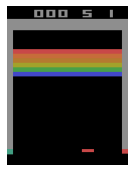

In [24]:
# env.render()

frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        obs, r, done, _ = env.step(env.action_space.sample())
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
 
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())